In [67]:
import pandas as pd
import pickle
import numpy as np

In [68]:
# 加载本问需要用到的数据
with open('所有会员消费.pkl', 'rb') as f:
    df3 = pickle.load(f)
df3['dtime'] = df3['dtime'].astype('datetime64[D]')

In [69]:
df3.head()

,kh,dtime,spbm,sl,sj,je,spmc,jf,djh,gzbm,gzmc,lbbm,ppbm,csbm,wsjj,hsjj,jxs,xxs,jlrq
0,5bfd4a2e,2016-05-08,9096d06f,1,1250.0,1125.0,素然B价件,0.0,25bb,3268,ZUCZUG,70101,1066,1146,0.0,0.0,1.17,1.17,2012-09-12 17:20:00
1,0a69471f,2016-05-08,9096d06f,1,1850.0,1665.0,素然B价件,0.0,fcd0,3268,ZUCZUG,70101,1066,1146,0.0,0.0,1.17,1.17,2012-09-12 17:20:00
2,0a69471f,2016-05-08,9096d06f,1,695.0,625.5,素然B价件,0.0,fcd0,3268,ZUCZUG,70101,1066,1146,0.0,0.0,1.17,1.17,2012-09-12 17:20:00
3,49e89b58,2016-05-08,9096d06f,1,1300.0,1170.0,素然B价件,0.0,7cd8,3268,ZUCZUG,70101,1066,1146,0.0,0.0,1.17,1.17,2012-09-12 17:20:00
4,49e89b58,2016-05-08,9096d06f,1,1400.0,1260.0,素然B价件,0.0,7cd8,3268,ZUCZUG,70101,1066,1146,0.0,0.0,1.17,1.17,2012-09-12 17:20:00


第二问的思路是使用综合评价模型，建立指标体系

购买日概念：会员在这天消费了，这天就是一个购买日

时间指标：购买频率（购买日数/成为会员天数），时间间隔（相邻两购买日之间的间隔天数均值），可以反映会员对商场的忠实度。

消费水平指标：每个购买日的消费总额中位数，均值，方差，可以反映用户的收入情况。

回购指标：相同商品/商品类型/专柜最大重复购买次数，购买数量均值，可以反映会员对该商场商品的依赖程度。

In [70]:
# 输入卡号，输出该会员的购买频率，平均购买间隔
def timeindex(kh):
    df31 = df3[df3['kh']==kh][['kh', 'dtime']]
    df32 = df31.drop_duplicates()
    df32 = df32.sort_values(by='dtime')
    df32['dist'] = df32['dtime'] - df32['dtime'].shift()
    alldays = pd.to_datetime('2018-01-01') - df32.iloc[0,1]
    gmpl = df32.shape[0]/alldays.days
    gmjgavg = df32['dist'][1:].mean().days if df32.shape[0]>1 else 0
    return  gmpl, gmjgavg

In [71]:
# 输入卡号，输出金额中位数，均值，方差
def payindex(kh):
    df31 = df3[df3['kh']==kh][['dtime', 'je']]
    df32 = df31.groupby('dtime').sum()
    je_avg = df32['je'].mean()
    je_med = df32['je'].median()
    je_var = df32['je'].std()
    return je_med, np.around(je_avg, 1), np.around(je_var,1)

In [72]:
# 输入卡号，输出相同商品/商品类型/专柜最多重复购买次数，购买数量均值
def hgindex(kh):
    df31 = df3[df3['kh']==kh][['dtime','sl', 'spmc' , 'lbbm', 'gzbm']]
    sphgavg = df31[['sl', 'spmc']].groupby('spmc').sum().max()[0] # 商品最多回购
    lbhgavg = df31[['sl', 'lbbm']].groupby('lbbm').sum().max()[0] # 类别最多回购
    gzhbavg = df31[['sl', 'gzbm']].groupby('gzbm').sum().max()[0] # 柜组最多回购
    slavg = df31[['sl']].mean()[0]
    return sphgavg, lbhgavg, gzhbavg,slavg

In [84]:
# 对20个会员进行价值识别

# n个评价对象，m个评价指标
n = 20
m = 9
judgeMatrix = np.zeros((n,m))  

n_hy = list(df3['kh'].drop_duplicates())[:n]
for i, hy in enumerate(n_hy):
    feature = timeindex(hy) + payindex(hy) + hgindex(hy)
    judgeMatrix[i,:] = feature

In [99]:
judgeMatrix_pd = pd.DataFrame(judgeMatrix, 
                              columns=['购买频率','平均购买间隔','金额中位数','金额均值','金额方差','商品最多回购','类型最多回购','专柜最多回购','数量均值'])

In [100]:
# 需要正向化的指标：'平均购买间隔','金额方差'
judgeMatrix_pd['平均购买间隔'] = judgeMatrix_pd['平均购买间隔'].max() - judgeMatrix_pd['平均购买间隔'] 
judgeMatrix_pd['金额方差'] = judgeMatrix_pd['金额方差'].max() - judgeMatrix_pd['金额方差']
# 归一化
judgeMatrix_pd = judgeMatrix_pd/judgeMatrix_pd.max(axis=0)

In [101]:
judgeMatrix_pd

,购买频率,平均购买间隔,金额中位数,金额均值,金额方差,商品最多回购,类型最多回购,专柜最多回购,数量均值
0,0.117459,0.783599,0.109482,0.085224,0.983656,0.026786,0.054217,0.023810,0.857143
1,0.133180,0.933941,0.093338,0.207699,0.866953,0.053571,0.060241,0.055556,0.857143
2,0.022230,0.000000,0.367438,0.245173,1.000000,0.035714,0.024096,0.031746,1.000000
3,0.032600,0.482916,0.208109,0.187882,0.891407,0.044643,0.042169,0.047619,0.964286
4,0.078665,0.797267,0.498024,0.519870,0.535850,0.098214,0.126506,0.087302,0.857143
5,0.042908,0.596811,0.866163,0.534152,0.763751,0.017857,0.048193,0.023810,0.857143
6,0.180647,0.863326,0.144647,0.130269,0.938124,0.107143,0.138554,0.142857,0.857143
7,0.618553,0.979499,0.217109,0.244058,0.812220,0.267857,0.234940,0.285714,0.890110
8,0.056343,1.000000,0.222676,0.175413,0.994101,0.035714,0.036145,0.047619,0.857143
9,0.193728,0.876993,1.000000,1.000000,0.000000,0.071429,0.132530,0.071429,0.857143


In [103]:
def topsis(a):
    cplus=a.max(axis=0)   #逐列求最大值
    cminus=a.min(axis=0)  #逐列求最小值
    # print("正理想解=",cplus,"s负理想解=",cminus)
    d1=np.linalg.norm(a-cplus, axis=1)  #求到正理想解的距离
    d2=np.linalg.norm(a-cminus, axis=1) #求到负理想解的距离
    # print(d1, d2)   #显示到正理想解和负理想解的距离
    f1=d2/(d1+d2)
    return f1
score = topsis(judgeMatrix_pd.values)

In [104]:
np.argsort(score)

array([ 2,  3,  0, 17,  4,  1, 19,  6, 11,  8,  5, 13, 10,  9, 14, 12,  7,
       18, 16, 15], dtype=int64)

In [105]:
judgeMatrix_pd['kh'] = n_hy
judgeMatrix_pd[['kh']]

,kh
0,5bfd4a2e
1,0a69471f
2,49e89b58
3,f0b36fcc
4,02f5944c
5,021b533e
6,ca9cfa81
7,5cf7c563
8,48f18b61
9,aa586401


In [106]:
# 接下来通过画图的方式验证排序的合理性
import seaborn as sns
import matplotlib.pyplot as plt
df20 = []
for hy in allhy:
    df20.append(df3[df3['kh'] == hy])

df20 = pd.concat(df20)

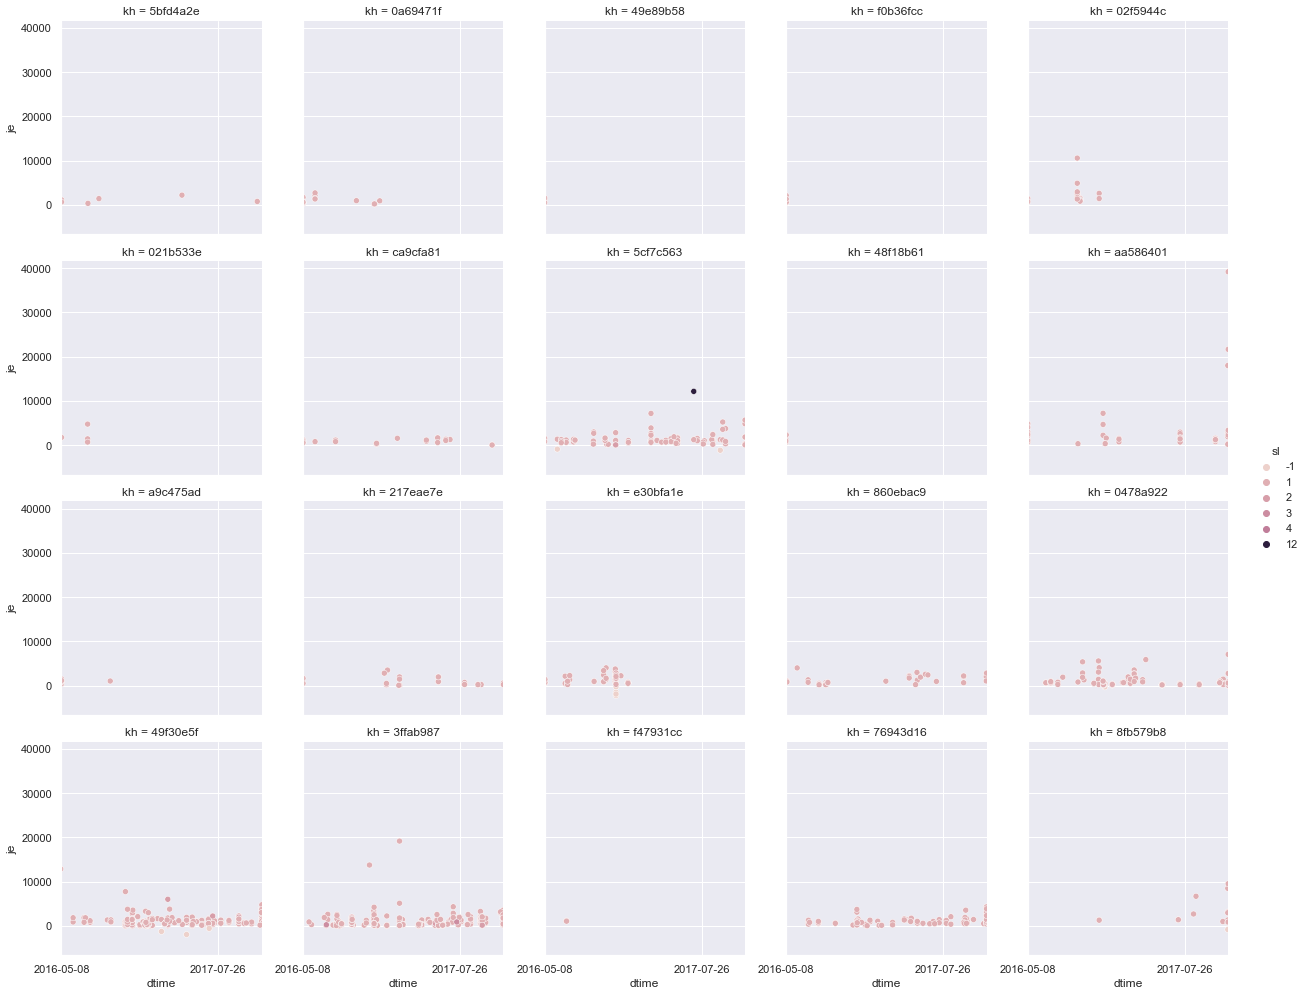

In [127]:
sns.set_theme(style="darkgrid")
fig = sns.relplot(data=df20, x='dtime', y='je', hue='sl', col='kh',col_wrap=5,height=3.5)
fig.despine()
xdates = [date for date in df20['dtime'][::200]]
fig.set(xlim=(xdates[0], xdates[-1]), xticks=xdates[::5])
fig.tight_layout()

散点密集的会员，在TOPSIS中排名确实靠前，说明了购买力评价模型的合理性。